In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 1.3MB 12.8MB/s 
     |████████████████████████████████| 1.1MB 35.3MB/s 
     |████████████████████████████████| 890kB 50.9MB/s 
     |████████████████████████████████| 2.9MB 49.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101034 sha256=80efabbaa836ad600afb7a414c2d94b89af0029d5a1e60acf7bdbb22670314c0
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=14f8a7fb0f386451c3af536e8401d6dca4697bdcd94afec1817305c1a78f054d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN
import string
import unicodedata
# from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

In [ ]:
# loading the dataset
train=pd.read_csv("/content/drive/My Drive/3rd Sem/Code v0.2/excel_data/summarydata-xlnet-gpt2.csv", encoding= 'unicode_escape')

In [ ]:
train.head()

,News_ID,GPT-2,XLNET
0,1,"Abu Dhabi [UAE], October 7 (ANI): USA pacer Al...","Abu Dhabi [UAE], October 7 (ANI): USA pacer Al..."
1,2,"Abu Dhabi [UAE], October 6 (ANI): England and ...","Abu Dhabi [UAE], October 6 (ANI): England and ..."
2,3,"Sydney [Australia], October 7 (ANI): Arjun Nai...","Sydney [Australia], October 7 (ANI): Arjun Nai..."
3,4,"Sydney [Australia], October 7 (ANI): Sydney Th...","Sydney [Australia], October 7 (ANI): Sydney Th..."
4,5,"Abu Dhabi [UAE], October 6 (ANI): Mumbai India...","Abu Dhabi [UAE], October 6 (ANI): Mumbai India..."


In [ ]:
train.dropna(inplace=True)

In [ ]:
train.isnull().sum()

News_ID    0
GPT-2      0
XLNET      0
dtype: int64

In [ ]:
#convert each question to a list of string
data = pd.Series(train["XLNET"].tolist()).astype(str)

In [ ]:
data.head()

0    Abu Dhabi [UAE], October 7 (ANI): USA pacer Al...
1    Abu Dhabi [UAE], October 6 (ANI): England and ...
2    Sydney [Australia], October 7 (ANI): Arjun Nai...
3    Sydney [Australia], October 7 (ANI): Sydney Th...
4    Abu Dhabi [UAE], October 6 (ANI): Mumbai India...
dtype: object

In [ ]:
data1 = data[:100]

In [ ]:
sentences_list = data

## Text Preprocessing

In [ ]:
nlp = spacy.load('en_core_web_sm')
# stop_list = ['best','different',"won\'t", "couldn\'t", "mustn\'t", "didn\'t", "dtype object"]
# for word in stop_list:
#     spacy.lang.en.stop_words.STOP_WORDS.add(word)
#     nlp.vocab[word].is_stop = True

In [ ]:
def normalize(data):
    """Run all the functions for preprocessing in a pipeline"""
    clean_data = re.sub(re.compile('<.*?>'), '', data)
    cleaned_list = [ unicodedata.normalize('NFKD', word.text).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in  nlp(clean_data)]
    cleaned_list = " ".join(cleaned_list)
    cleaned_list = [word.text.rstrip('0123456789').lower() for word in nlp(cleaned_list) if word.pos_  in ['NOUN','PROPN', 'VERB'] and not word.is_digit and not word.is_punct and not word.is_stop ]
    return cleaned_list

In [ ]:
# Preprocess the text data
normalized_data = []
for i, batch in data.groupby(np.arange(len(data)) // 10):
    for batch_data in batch:
        normalized_data.append(normalize(batch_data))

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Data after prerocessing
print(normalized_data[0])
len(normalized_data)

['abu', 'dhabi', 'uae', 'october', 'ani', 'usa', 'pacer', 'ali', 'khan', 'ruled', 'indian', 'premier', 'league', 'ipl', 'injury', 'kolkata', 'knight', 'riders', 'signed', 'ali', 'khan', 'replacement', 'injured', 'harry', 'gurney', 'cpl', 'title', 'win', 'tkr']


9048

In [ ]:
# function to form sentences from token
sentence = []
sentences = []


def token_2_sentence(normalized_data):
    """Join the tokens in each list with space to form a sentence"""
    for i in normalized_data:
      sentence = " ".join(i)
      sentences.append(sentence)
      sentence = [] 
    return sentences
    
sentences_list = token_2_sentence(normalized_data)

In [ ]:
sentences_list[:10]

['abu dhabi uae october ani usa pacer ali khan ruled indian premier league ipl injury kolkata knight riders signed ali khan replacement injured harry gurney cpl title win tkr',
 'abu dhabi uae october ani england rajasthan royals rounder ben stokes reckons kartik tyagi run pacer brett lee delivers ball ishant sharma opting bat mumbai indians posted runs allotted overs suryakumar yadav scintillating batting performance rohit sharma led lost way overs royals tyagi jofra archer picked wicket shreyas gopal scalped match',
 'sydney australia october ani arjun nair signed big bash league bbl season sydney thunder tuesday sydney thunder home sydney thunder coach shane bond described nair skill allied willingness situation assets help provide sydney thunder season edge sydney thunder set open bbl campaign december melbourne stars mcg playing game sydney showground stadium december perth scorchers',
 'sydney australia october ani sydney thunder completed squad women big bash league season signi

In [ ]:
import csv
with open('./normalized.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow("Normalized")

In [ ]:
for item in sentences_list:
  with open('./normalized.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([item])

In [ ]:
# sentences_list = pd.read_csv("./normalized.csv")
# sentences_list = sentences_list.values.tolist()
# sentences_list[0]

In [ ]:
# sentences_list[0][0]

## Clustering with Embedding

In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

100%|██████████| 245M/245M [00:16<00:00, 14.9MB/s]


In [ ]:
def data_gen(data):
    for sen in data:
      yield sen

In [ ]:
a = data_gen(sentences_list)

In [ ]:
encoding_arr = list()
current = 1
for item in a:
  embeddings = model.encode(item)
  encoding_arr.append(embeddings)
  print("Current:",current)
  current += 1

Streaming output truncated to the last 5000 lines.
Current: 4049
Current: 4050
Current: 4051
Current: 4052
Current: 4053
Current: 4054
Current: 4055
Current: 4056
Current: 4057
Current: 4058
Current: 4059
Current: 4060
Current: 4061
Current: 4062
Current: 4063
Current: 4064
Current: 4065
Current: 4066
Current: 4067
Current: 4068
Current: 4069
Current: 4070
Current: 4071
Current: 4072
Current: 4073
Current: 4074
Current: 4075
Current: 4076
Current: 4077
Current: 4078
Current: 4079
Current: 4080
Current: 4081
Current: 4082
Current: 4083
Current: 4084
Current: 4085
Current: 4086
Current: 4087
Current: 4088
Current: 4089
Current: 4090
Current: 4091
Current: 4092
Current: 4093
Current: 4094
Current: 4095
Current: 4096
Current: 4097
Current: 4098
Current: 4099
Current: 4100
Current: 4101
Current: 4102
Current: 4103
Current: 4104
Current: 4105
Current: 4106
Current: 4107
Current: 4108
Current: 4109
Current: 4110
Current: 4111
Current: 4112
Current: 4113
Current: 4114
Current: 4115
Current: 41

In [ ]:
encoded_arr = np.array(encoding_arr)
encoded_arr_gpt2 = encoded_arr
encoded_arr_gpt2.shape

(9048, 768)

In [ ]:
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
def tagged_document(normalized_data):
    tagged_corpus = []
    tagged_corpus = [TaggedDocument(words = d, tags=[str(i)]) for i,d in enumerate(normalized_data)]
    return tagged_corpus

In [ ]:
tagged_corpus =  tagged_document(normalized_data)

In [ ]:
tagged_corpus

[TaggedDocument(words=['abu', 'dhabi', 'uae', 'october', 'ani', 'usa', 'pacer', 'ali', 'khan', 'ruled', 'indian', 'premier', 'league', 'ipl', 'injury', 'kolkata', 'knight', 'riders', 'signed', 'ali', 'khan', 'replacement', 'injured', 'harry', 'gurney', 'cpl', 'title', 'win', 'tkr'], tags=['0']),
 TaggedDocument(words=['abu', 'dhabi', 'uae', 'october', 'ani', 'england', 'rajasthan', 'royals', 'rounder', 'ben', 'stokes', 'reckons', 'kartik', 'tyagi', 'run', 'pacer', 'brett', 'lee', 'delivers', 'ball', 'ishant', 'sharma', 'opting', 'bat', 'mumbai', 'indians', 'posted', 'runs', 'allotted', 'overs', 'suryakumar', 'yadav', 'scintillating', 'batting', 'performance', 'rohit', 'sharma', 'led', 'lost', 'way', 'overs', 'royals', 'tyagi', 'jofra', 'archer', 'picked', 'wicket', 'shreyas', 'gopal', 'scalped', 'match'], tags=['1']),
 TaggedDocument(words=['sydney', 'australia', 'october', 'ani', 'arjun', 'nair', 'signed', 'big', 'bash', 'league', 'bbl', 'season', 'sydney', 'thunder', 'tuesday', 'sydn

In [ ]:

def build_model(tagged_corpus,max_epochs,vec_size, alpha):  
    model = Doc2Vec(size=vec_size, alpha=alpha,min_alpha=0.001, min_count=1,dm =1)
    model.build_vocab(tagged_corpus)

    for epoch in range(max_epochs):
        model.train(tagged_corpus,total_examples=model.corpus_count, epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

        
    model.save("d2v.model")
    print("Model Saved")
    model_name = "d2v.model"
    return model_name


In [ ]:
# from gensim.models.doc2vec import Doc2Vec

def load_model(model_name, data):
    corpus_vector = []
    model= Doc2Vec.load(model_name)
    for doc in data:
        corpus_vector.append(model.infer_vector(doc.split()))
    return corpus_vector

In [ ]:
max_epochs = 100
vec_size = 100
alpha = 0.001
model_name = build_model(tagged_corpus,max_epochs,vec_size, alpha)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


Model Saved


In [ ]:
corpus_vector = load_model("d2v.model",data)  

In [ ]:
corpus_vector = np.array(corpus_vector)

In [ ]:
corpus_vector.shape

(9048, 100)

In [ ]:
#KMeans (WITHOUT Dimensionality Reduction)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans(corpus_vector):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
    # pca = PCA(n_components=2)
    # result = pca.fit_transform(corpus_vector)
    # print(result.shape)

    Sum_of_squared_distances = []
    K = range(10,30)
    for k in K:
      km = KMeans(n_clusters=k, max_iter=200, n_init=10)
      km = km.fit(corpus_vector)
      Sum_of_squared_distances.append(km.inertia_)
      print(Sum_of_squared_distances[-1])
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
 


In [ ]:
#K-Means on BERT Embedding

636226.0324123233
628973.8118242959
622017.4900697161
615828.3449469479
609725.3463181213
604594.2566440391
600650.9279740779
596480.4479859769
592284.740296833
588372.4161972597
585212.4296981939
582143.8975672007
578342.2957697631
575470.4618724076
573107.9021732396
569223.0575977203
566010.5284941453
564815.6141669714
561504.6678504735
559502.8424815659


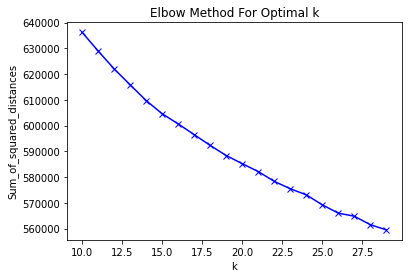

In [ ]:
kmeans(encoded_arr_gpt2)

In [ ]:
#K-Means on Doc2Vec Embedding

595.2052971046071
498.3961963259021
424.85619221293695
363.90301615043563
314.131308092469
273.30019552791697
241.0352172027823
212.70686324965433
184.70589215744454
161.50985955189276
141.5167325296013
127.22148430703739
115.70601297996417
106.87262962339061
97.41163393995076
90.07300019001077
82.86541267159937
77.4268748899201
72.03460478839611
67.35406153240491


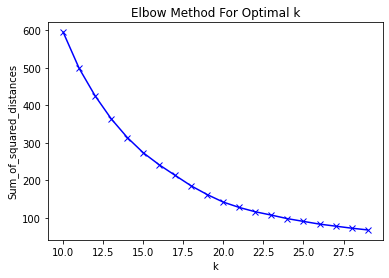

In [ ]:
kmeans(corpus_vector)

In [ ]:
#KMeans (WITH Dimensionality Reduction PCA)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_pca(corpus_vector):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(corpus_vector)
    print(result.shape)

    Sum_of_squared_distances = []
    K = range(10,30)
    for k in K:
      km = KMeans(n_clusters=k, max_iter=200, n_init=10)
      km = km.fit(result)
      Sum_of_squared_distances.append(km.inertia_)
      print(k,":",Sum_of_squared_distances[-1])
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
 
    

(9048, 2)
10 : 18560.953165198403
11 : 16941.98028871723
12 : 15560.145491031366
13 : 14447.949595274118
14 : 13448.976200781664
15 : 12648.336964584621
16 : 11823.031852330876
17 : 11127.175079239358
18 : 10508.065434639233
19 : 10016.186003388093
20 : 9584.227048580493
21 : 9194.963335656228
22 : 8815.940349506627
23 : 8408.708616932508
24 : 8054.366870214579
25 : 7722.770213917418
26 : 7456.347378347164
27 : 7181.7400829122325
28 : 6922.813370109593
29 : 6689.579809549076


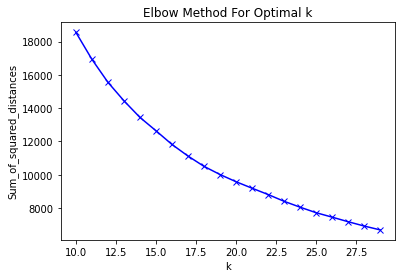

In [ ]:
##K-Means on BERT Embedding + PCA
kmeans_pca(encoded_arr_gpt2)

(9048, 2)
10 : 589.8270535416361
11 : 492.68293239377005
12 : 417.731480173745
13 : 356.9957108851029
14 : 307.4881037861577
15 : 267.8127340112212
16 : 236.3501422643724
17 : 205.12716869565094
18 : 177.8361509148462
19 : 154.310813229925
20 : 134.00469789229328
21 : 120.58393720231933
22 : 109.90203646650781
23 : 99.45126063720592
24 : 90.11679269751588
25 : 82.86848935640349
26 : 77.12506397161907
27 : 69.96821553014975
28 : 64.82797717915926
29 : 59.931441614213114


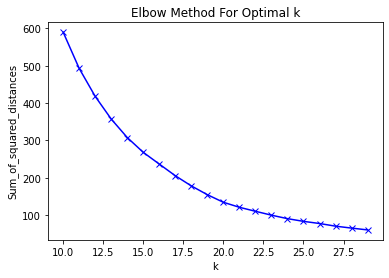

In [ ]:
##K-Means on Doc2Vec Embedding + PCA
kmeans_pca(corpus_vector)

In [ ]:
#KMeans (WITH Dimensionality Reduction T-SNE)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_tsne(corpus_vector):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
   # Initialize t-SNE
    tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
    # Use only 400 rows to shorten processing time
    result = tsne.fit_transform(corpus_vector)
    print(result.shape)

    Sum_of_squared_distances = []
    K = range(10,30)
    for k in K:
      km = KMeans(n_clusters=k, max_iter=200, n_init=10)
      km = km.fit(result)
      Sum_of_squared_distances.append(km.inertia_)
      print(k,":",Sum_of_squared_distances[-1])
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    

(9048, 2)
10 : 803553.9036114095
11 : 731874.6509677971
12 : 664052.4382794974
13 : 608375.1049985159
14 : 555030.3500704686
15 : 508757.1024201889
16 : 480702.5714086454
17 : 448770.7673411322
18 : 422944.3448997744
19 : 396396.9741545371
20 : 376731.21501901274
21 : 356827.59344433196
22 : 342695.1671310902
23 : 327992.25940867746
24 : 316552.04825420957
25 : 304099.1789397448
26 : 291423.7453893733
27 : 283406.0512863829
28 : 272492.583235071
29 : 260790.82284315466


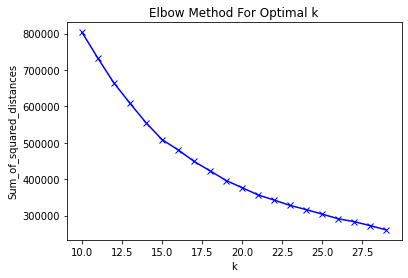

In [ ]:
##K-Means on BERT Embedding + t-SNE
kmeans_tsne(encoded_arr_gpt2)

(9048, 2)
10 : 1310723.232258192
11 : 1127150.2634369275
12 : 983638.7330644688
13 : 864367.1744404761
14 : 767983.2299486648
15 : 678309.9839990888
16 : 600015.4224532119
17 : 533924.7962152096
18 : 469093.9064445958
19 : 417351.54656462226
20 : 374410.48544527567
21 : 340791.01442558883
22 : 312374.88933397114
23 : 286989.1207015667
24 : 268047.0972165676
25 : 248336.53097968714
26 : 229237.0255422142
27 : 216141.1147729199
28 : 205286.21738679727
29 : 191752.46915827383


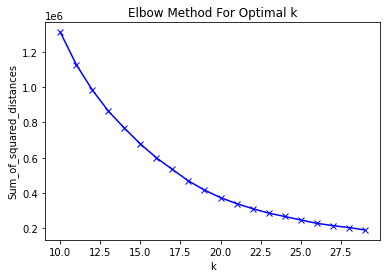

In [ ]:
##K-Means on Doc2Vec Embedding + t-SNE
kmeans_tsne(corpus_vector)

In [ ]:
def plot_kmeans_pca(true_k, corpus_vector):
  pca = PCA(n_components=2)
  result_pca = pca.fit_transform(corpus_vector)
  print(result_pca.shape)

  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
  model.fit(result_pca)
  print("SSD:",model.inertia_)
  labels=model.labels_
  print("Labels:",labels)
  y_pred = model.fit_predict(result_pca)
  plt.scatter(result_pca[:,0], result_pca[:,1],c=y_pred, cmap='Paired')
  plt.title("K-Means with k="+str(true_k))
  return labels

(9048, 2)
SSD: 133.8402222337754
Labels: [ 3 16  2 ... 19  4  9]


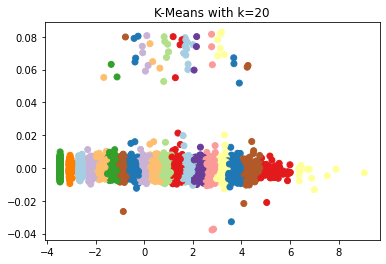

In [ ]:
 labels_kmeans_pca = plot_kmeans_pca(20, corpus_vector)

(9048, 2)
SSD: 9582.360340157447
Labels: [ 1 18  9 ... 17 16 10]


array([ 1, 18,  9, ..., 17, 16, 10], dtype=int32)

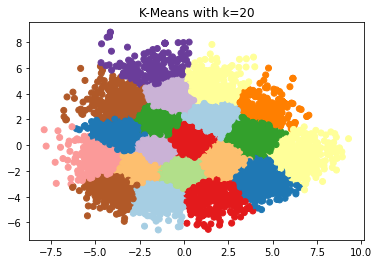

In [ ]:
plot_kmeans_pca(20, encoded_arr_gpt2)

In [ ]:
def plot_kmeans_tsne(true_k, corpus_vector):
  tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
  # Use only 400 rows to shorten processing time
  result_tsne = tsne.fit_transform(corpus_vector)
  print(result_tsne.shape)

  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
  model.fit(result_tsne)
  print("SSD:",model.inertia_)
  labels=model.labels_
  print(labels)
  y_pred = model.fit_predict(result_tsne)
  plt.scatter(result_tsne[:,0], result_tsne[:,1],c=y_pred, cmap='Paired')
  plt.title("K-Means with k="+str(true_k))

(9048, 2)
SSD: 375280.9844821786
[ 2 15 10 ...  3 18  9]


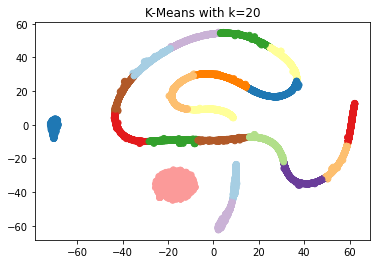

In [ ]:
plot_kmeans_tsne(20, corpus_vector)

(9048, 2)
SSD: 375852.4768484771
[ 3  3 15 ...  8  5  6]


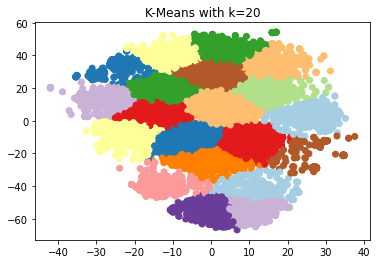

In [ ]:
plot_kmeans_tsne(20, encoded_arr_gpt2)

In [ ]:
labels1 = labels_kmeans_pca.tolist()

In [ ]:
total = 0 
for each in range(-1, 21):
  print(each, ":", labels1.count(each))
  total += labels1.count(each)

print(total)

-1 : 0
0 : 1050
1 : 647
2 : 546
3 : 378
4 : 537
5 : 192
6 : 428
7 : 427
8 : 354
9 : 653
10 : 563
11 : 12
12 : 526
13 : 324
14 : 509
15 : 281
16 : 400
17 : 643
18 : 54
19 : 524
20 : 0
9048


In [ ]:
list3 = [i for i, e in enumerate(labels1) if e == 2]

In [ ]:
combined_sent = ""
for each in list3:
  print(sentences_list[each])
  print()
  combined_sent += sentences_list[each]

sydney australia october ani arjun nair signed big bash league bbl season sydney thunder tuesday sydney thunder home sydney thunder coach shane bond described nair skill allied willingness situation assets help provide sydney thunder season edge sydney thunder set open bbl campaign december melbourne stars mcg playing game sydney showground stadium december perth scorchers

abu dhabi uae october ani reminiscing catch dismiss rajasthan royals mahipal lomror mumbai indians spinner anukul roy said dive catch realising ball roy come substitute fielder suryakumar yadav ended taking catch rahul chahar bowling dismiss lomror jos buttler came bat steve smith led played knock runs

new delhi india october ani players teams participating egoal social responsibility programme organised asian football confederation afc partnership aurora egoal social responsibility programme kicked monday consists total sessions conducted weeks concluding october session conducted titled sport sustainable developm

In [ ]:
wordlist = combined_sent.split()
wordfreq = {}
for w in wordlist:
  if w not in wordfreq:
    wordfreq[w] = 0 
  wordfreq[w] += 1
    

In [ ]:
sorted_words = dict(sorted(wordfreq.items(), key=lambda item: item[1],reverse=True))
print(sorted_words)

{'said': 372, 'india': 168, 'october': 141, 'oct': 114, 'delhi': 109, 'government': 94, 'rs': 90, 'minister': 90, 'ani': 78, 'coronavirus': 72, 'year': 70, 'police': 69, 'people': 69, 'thursday': 67, 'state': 65, 'photo': 63, 'singh': 60, 'states': 59, 'indian': 58, '|': 58, 'friday': 56, 'cases': 56, 'ipl': 53, 'country': 53, 'president': 53, 'credit': 53, 'world': 52, 'court': 51, 'time': 48, 'monday': 45, 'covid-': 44, 'trump': 44, 'cent': 43, 'day': 43, 'health': 42, 'khan': 41, 'years': 41, 'party': 41, 'wednesday': 41, 'news': 41, 'points': 41, 'lakh': 41, 'actor': 40, 'team': 39, 'match': 39, 'bjp': 38, 'according': 38, 'pandemic': 38, 'week': 37, 'accused': 37, 'kings': 36, 'leader': 35, 'film': 35, 'highlights': 35, 'tuesday': 34, 'set': 34, 'announced': 34, 'centre': 34, 'bank': 34, 'support': 33, 'prime': 33, 'company': 33, 'league': 32, 'number': 32, 'congress': 32, 'case': 32, 'sunday': 31, 'ministry': 31, 'says': 31, 'statement': 30, 'finance': 30, 'days': 30, 'today': 30

In [ ]:
# kmeans_pca(encoded_arr)

In [ ]:
# kmeans(encoded_arr)

In [ ]:
from sklearn.decomposition import PCA

def dbscan(corpus_vector, eps= 0.005, min_samples = 3):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(corpus_vector)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_model = db.fit(result)
    #Forming the clusters

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels1 = dbscan_model.labels_
    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
    print(labels1)
    print(len(labels1))
    print(n_clusters_) # number of clusters
    
    clusters1 = {} # a dictionary for different cluster 
    for c, i in enumerate(labels1):
        if i == -1:
            continue
        elif i in clusters1:
            clusters1[i].append( data[c] )
        else:
            clusters1[i] = [data[c]]

    for c in clusters1: # print the different clusters
        # print("Cluster No."+" "+str(c)+" "+str(clusters1[c]))
        # print()
        pass

    return labels1, clusters1

In [ ]:
labels1, clusters1 = dbscan(corpus_vector,0.005,3)

(9048, 2)
[ 0  1  2 ... 24 26  6]
9048
168


In [ ]:
labels1, clusters1 = dbscan(corpus_vector,0.01,3)

(9048, 2)
[0 1 0 ... 0 0 0]
9048
35


In [ ]:
labels1, clusters1 = dbscan(encoded_arr_gpt2,0.01,3)

(9048, 2)
[-1 -1 -1 ... -1 -1 -1]
9048
13


In [ ]:
labels1, clusters1 = dbscan(encoded_arr_gpt2,0.04,3)

(9048, 2)
[ -1  -1 293 ...  -1  -1 367]
9048
368


In [ ]:
from sklearn.decomposition import PCA

def plot_dbscan(X , eps, min_samples):
    """Function to plot clusters"""
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(result)
    y_pred = db.fit_predict(result)
    plt.scatter(result[:,0], result[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    


(9048, 2)


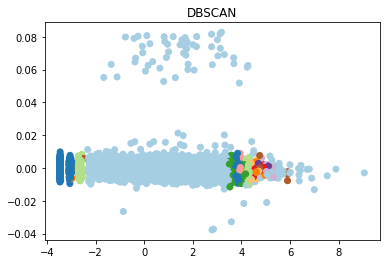

In [ ]:
plot_dbscan(corpus_vector,0.01,3)

(9048, 2)


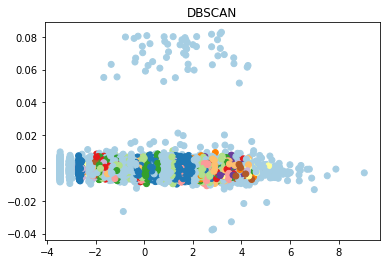

In [ ]:
plot_dbscan(corpus_vector,0.005,3)

(9048, 2)


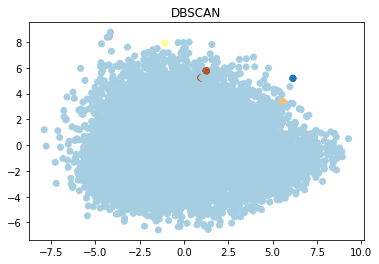

In [ ]:
plot_dbscan(encoded_arr_gpt2,0.01,3)

(9048, 2)


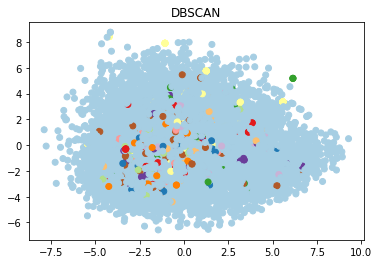

In [ ]:
plot_dbscan(encoded_arr_gpt2,0.04,3)

In [ ]:
labels1 = labels1.tolist()

In [ ]:
total = 0 
for each in range(-1, 150):
  print(each, ":", labels1.count(each))
  total += labels1.count(each)

print(total)

-1 : 177
0 : 301
1 : 33
2 : 1188
3 : 5252
4 : 420
5 : 472
6 : 48
7 : 371
8 : 281
9 : 5
10 : 73
11 : 44
12 : 96
13 : 3
14 : 6
15 : 36
16 : 9
17 : 10
18 : 14
19 : 5
20 : 12
21 : 3
22 : 4
23 : 15
24 : 5
25 : 8
26 : 23
27 : 5
28 : 4
29 : 11
30 : 18
31 : 7
32 : 7
33 : 7
34 : 7
35 : 5
36 : 12
37 : 3
38 : 4
39 : 4
40 : 8
41 : 4
42 : 3
43 : 3
44 : 3
45 : 3
46 : 0
47 : 0
48 : 0
49 : 0
50 : 0
51 : 0
52 : 0
53 : 0
54 : 0
55 : 0
56 : 0
57 : 0
58 : 0
59 : 0
60 : 0
61 : 0
62 : 0
63 : 0
64 : 0
65 : 0
66 : 0
67 : 0
68 : 0
69 : 0
70 : 0
71 : 0
72 : 0
73 : 0
74 : 0
75 : 0
76 : 0
77 : 0
78 : 0
79 : 0
80 : 0
81 : 0
82 : 0
83 : 0
84 : 0
85 : 0
86 : 0
87 : 0
88 : 0
89 : 0
90 : 0
91 : 0
92 : 0
93 : 0
94 : 0
95 : 0
96 : 0
97 : 0
98 : 0
99 : 0
100 : 0
101 : 0
102 : 0
103 : 0
104 : 0
105 : 0
106 : 0
107 : 0
108 : 0
109 : 0
110 : 0
111 : 0
112 : 0
113 : 0
114 : 0
115 : 0
116 : 0
117 : 0
118 : 0
119 : 0
120 : 0
121 : 0
122 : 0
123 : 0
124 : 0
125 : 0
126 : 0
127 : 0
128 : 0
129 : 0
130 : 0
131 : 0
132 : 0
133 : 0

In [ ]:
[i for i, e in enumerate(labels1) if e == 3]

[3,
 5,
 7,
 10,
 11,
 13,
 14,
 15,
 23,
 24,
 26,
 27,
 29,
 30,
 31,
 32,
 34,
 36,
 37,
 39,
 40,
 41,
 42,
 45,
 48,
 50,
 52,
 54,
 61,
 63,
 67,
 72,
 73,
 74,
 75,
 76,
 78,
 80,
 84,
 85,
 87,
 88,
 92,
 93,
 97,
 99,
 102,
 103,
 104,
 111,
 112,
 114,
 116,
 117,
 119,
 120,
 127,
 128,
 129,
 130,
 132,
 134,
 135,
 138,
 139,
 143,
 144,
 145,
 146,
 149,
 150,
 152,
 153,
 157,
 158,
 161,
 162,
 165,
 167,
 168,
 171,
 172,
 173,
 174,
 177,
 178,
 179,
 180,
 184,
 185,
 186,
 189,
 190,
 192,
 194,
 196,
 199,
 204,
 205,
 208,
 209,
 210,
 214,
 217,
 218,
 220,
 221,
 222,
 223,
 225,
 226,
 232,
 235,
 240,
 241,
 242,
 244,
 246,
 247,
 249,
 252,
 254,
 255,
 257,
 259,
 261,
 263,
 264,
 265,
 266,
 269,
 271,
 272,
 273,
 274,
 275,
 277,
 278,
 279,
 282,
 283,
 284,
 286,
 289,
 291,
 292,
 299,
 300,
 301,
 303,
 304,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 315,
 316,
 320,
 323,
 324,
 325,
 326,
 327,
 328,
 331,
 334,
 341,
 342,
 344,
 346,
 350,

In [ ]:
print(sentences_list[20])
print()
print(sentences_list[1468])
print()
print(sentences_list[1523])

abu dhabi uae october ani stumbling defeat hands mumbai indians rajasthan royals wicket keeper batsman jos buttler said team recover losing wickets powerplay managed come order games lost wickets powerplay games win t matches position course powerplay time advantage fielding restrictions players performed happen t cricket buttler said replying ani query press conference

new york usa october ani newsvoir support expansion testing contact tracing india rockefeller foundation announced grants center cellular molecular platforms path.the grants totaling support manufacturing testing materials deployment testing programs mitigating virus spread date foundation dedicated grants supporting frontline organizations africa asia strengthening united states response

new delhi india october ani newsvoir arjun anand author art photographer launched book hamir fallen prince ranthambore webinar called tiffin talks focus hamir tigers ranthambore carries glimpses park


(9032, 2)


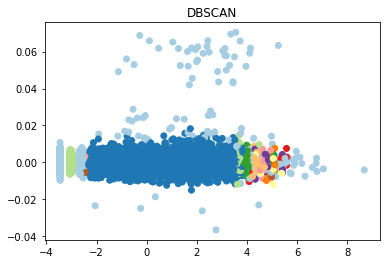

In [ ]:
from sklearn.decomposition import PCA

def plot_dbscan(X , eps, min_samples):
    """Function to plot clusters"""
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(result)
    y_pred = db.fit_predict(result)
    plt.scatter(result[:,0], result[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    
plot_dbscan(corpus_vector,0.01,3)

(9032, 2)


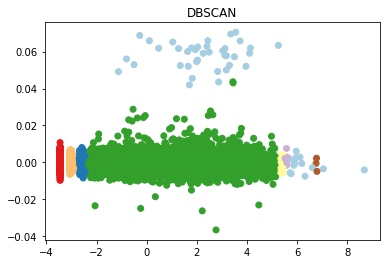

In [ ]:
plot_dbscan(corpus_vector,0.03, 3)

(9032, 2)


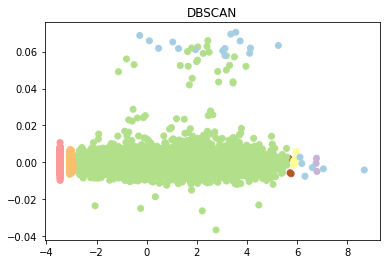

In [ ]:
plot_dbscan(corpus_vector,0.05, 3)